In [7]:
from itertools import pairwise
from torch import nn, Tensor
# from torch.nn.utils.parametrizations import spectral_norm
spectral_norm = lambda x: x


class TransformerPrefModel(nn.Module):
    def __init__(self, d_model: int, num_layers: int):
        super().__init__()
        assert d_model % 64 == 0, "d_model must be divisible by 64"

        self.input_linear = nn.LazyLinear(d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model, nhead=d_model // 64, dim_feedforward=d_model * 4,
                activation='gelu', batch_first=True, norm_first=True
            ),
            num_layers=num_layers
        )
        self.reward_linear = nn.Linear(d_model, 1)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.input_linear(x)
        x = self.transformer(x)
        x = self.reward_linear(x)
        return x.flatten(1).sum(1)
    
    def pref_logit(self, a: Tensor, b: Tensor) -> Tensor:
        return self(a) - self(b)


In [50]:
import gpytorch as gp
import math


class VariationalGP(gp.models.ApproximateGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        variational_distribution = gp.variational.CholeskyVariationalDistribution(
            num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
        )

        # Our base variational strategy is a GridInterpolationVariationalStrategy,
        # which places variational inducing points on a Grid
        variational_strategy = gp.variational.GridInterpolationVariationalStrategy(
            self, grid_size=grid_size, grid_bounds=[grid_bounds],
            variational_distribution=variational_distribution,
        )
        super().__init__(variational_strategy)

        self.covar_module = gp.kernels.ScaleKernel(
            gp.kernels.RBFKernel(
                lengthscale_prior=gp.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gp.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean, covar)



In [8]:
from sngp_torch import RandomFeatureGP
from itertools import pairwise
from torch import nn, Tensor
from torch.distributions import MultivariateNormal, Normal
from torch.nn.utils.parametrizations import spectral_norm
import gpytorch as gp


class VariationalPrefModel(nn.Module):
    def __init__(self, hiddens: list[int]):
        super().__init__()

        # Normalize observations and actions to have mean 0 and std 1
        # self.obs_norm = nn.BatchNorm1d(hiddens[0])
        self.hidden_layers = nn.Sequential()

        for i, j in pairwise(hiddens):
            self.hidden_layers.append(spectral_norm(nn.Linear(i, j)))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(0.1))

        self.gp = VariationalGP(hiddens[-1])
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.hidden_layers(x)
        return self.gp(x).flatten(1).mean(1)
    
    def posterior(self, x: Tensor) -> MultivariateNormal | Normal:
        x = self.hidden_layers(x)
        return self.gp(x)
    
    def pref_logit(self, a: Tensor, b: Tensor) -> Tensor:
        return self(a) - self(b)



In [10]:
from torch import nn, Tensor
import torch

def permutation_loss(scores: Tensor, labels: Tensor) -> Tensor:
    # Sort predicted scores by their GT rewards/ranks, lowest to highest
    scores = scores[labels.argsort()]

    # We imagine that the GT ranking was generated sequentially in descending
    # order, by sampling *without replacement* from the available options in
    # proportion to exp(scores). The option set shrinks by one every time a
    # choice is made; e.g. the highest ranked option was selected from among the
    # entire set of options, the second highest from the whole set minus the
    # one just picked, etc. This allows us to efficiently compute the log-likelihood
    # of the GT ranking using a log-cumsum-exp trick.
    stabilizer = scores.max()
    exp_scores = torch.exp(scores - stabilizer)
    log_normalizer = exp_scores.cumsum(0).add(1e-7).log()

    return -torch.mean(scores - log_normalizer - stabilizer)

scores = nn.Parameter(torch.rand(11))
for i in range(1000):
    scores.grad = None

    loss = permutation_loss(scores, torch.arange(11))
    loss.backward()

    g = scores.grad
    with torch.no_grad():
        scores -= g

print(f"{scores.grad.norm()=}")

scores.grad.norm()=tensor(2.5628e-05)


In [1]:
from classroom.datasets import SyntheticPairwisePrefs
import numpy as np


ds = SyntheticPairwisePrefs(
    '/home/nora/value-learning/ant/seed_0',
    transform=lambda x: torch.from_numpy(
        np.concatenate([x.state.obs, x.action], axis=-1)
    )
)

In [47]:
from torch import nn, Tensor
from typing import Iterable, SupportsFloat
import torch
import torch.nn.functional as F


def mean_update(running_mean, new_value, n: int):
    """Online update of a running mean."""
    return (n * running_mean + new_value) / (n + 1)


class PairwisePrefModel(nn.Module):
    def pref_logit(self, a: Tensor, b: Tensor) -> Tensor:
        batch = torch.cat([a, b])
        a_pred, b_pred = self(batch).chunk(2)
        return a_pred - b_pred
    
    @torch.no_grad()
    def test(self, data: Iterable[tuple[Tensor, Tensor, Tensor]]) -> dict[str, float]:
        was_training = self.training
        self.eval()

        metrics: dict[str, SupportsFloat] = {'accuracy': 0, 'loss': 0}
        for i, (a, b, pref) in enumerate(data):
            pref = pref.cuda()
            pref_logit = self.pref_logit(a.cuda(), b.cuda())
            hits = pref == (pref_logit > 0)

            metrics['accuracy'] = mean_update(
                metrics['accuracy'], hits.float().mean(), i
            )
            metrics['loss'] = mean_update(
                metrics['loss'],
                F.binary_cross_entropy_with_logits(pref_logit, pref.float()), i
            )
        
        self.training = was_training
        return {k: float(v) for k, v in metrics.items()}


In [48]:
from sngp_torch import RandomFeatureGP
from itertools import pairwise
from torch import nn, Tensor
from torch.distributions import MultivariateNormal, Normal
from torch.nn.utils.parametrizations import spectral_norm
import gpytorch as gp


class GpPrefModel(PairwisePrefModel):
    def __init__(self, hiddens: list[int]):
        super().__init__()

        # Normalize observations and actions to have mean 0 and std 1
        self.hidden_layers = nn.Sequential()

        for i, j in pairwise(hiddens):
            self.hidden_layers.append(spectral_norm(nn.Linear(i, j)))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(0.1))

        self.gp = RandomFeatureGP(hiddens[-1], 1, loss_fn=None)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.hidden_layers(x)
        return self.gp(x).flatten(1).mean(1)
    
    def posterior(self, x: Tensor) -> MultivariateNormal | Normal:
        x = self.hidden_layers(x)
        return self.gp.posterior(x)
    
    def update_covariance(self, x: Tensor, labels: Tensor):
        hidden = self.hidden_layers(x)
        phi = self.gp.featurize(hidden)

        def loss_fn(w):
            scores = torch.squeeze(phi @ w.T + self.gp.linear.bias)
            return permutation_loss(scores, labels)
        
        hess = torch.autograd.functional.hessian(
            loss_fn, self.gp.linear.weight, vectorize=True
        )
        assert isinstance(hess, Tensor)
        self.gp.update_precision(hess.squeeze().cuda())


In [49]:
from sngp_torch import RandomFeatureGP
from itertools import pairwise
from torch import nn, Tensor
from torch.distributions import MultivariateNormal, Normal
from torch.nn.utils.parametrizations import spectral_norm
import gpytorch as gp


class MlpPrefModel(PairwisePrefModel):
    def __init__(self, hiddens: list[int]):
        super().__init__()

        # Normalize observations and actions to have mean 0 and std 1
        self.hidden_layers = nn.Sequential()

        for i, j in pairwise(hiddens):
            self.hidden_layers.append(spectral_norm(nn.Linear(i, j)))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(0.1))

        self.output = nn.Linear(hiddens[-1], 1)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.hidden_layers(x)
        return self.output(x).flatten(1).mean(1)


In [7]:
from scipy.stats import kendalltau, rankdata, spearmanr
from torch.optim import AdamW
from torch import Tensor
import torch
import torch.nn.functional as F


class RankCorrelation:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.scores = []
        self.labels = []
    
    def update(self, scores: Tensor, labels: Tensor) -> None:
        self.scores.append(scores.detach().cpu())
        self.labels.append(labels.detach().cpu())
    
    def compute(self):
        scores = np.concatenate(self.scores, axis=0)
        labels = np.concatenate(self.labels, axis=0)
        return kendalltau(scores, labels).correlation

rank_corr = RankCorrelation()

def permutation_fit(model, train_dl, val_dl):
    adam = AdamW(model.parameters())
    
    last_val_corr = -1.0
    val_corr = 0.0

    while True:
        rank_corr.reset()
        model.train()
        
        train_losses = []
        for clip_batch, labels in train_dl:
            clip_batch, labels = clip_batch.cuda(), labels.cuda()
            noised_labels = labels + torch.randn_like(labels) * torch.std(labels)
            loss = permutation_loss(model(clip_batch), noised_labels)
            loss.backward()

            adam.step()
            adam.zero_grad()
            train_losses.append(loss.detach().cpu())

        with torch.no_grad():
            model.eval()

            for clip_batch, rewards in val_dl:
                scores = model(clip_batch.cuda())
                rank_corr.update(scores, rewards)
        
        val_corr = rank_corr.compute()
        if val_corr < last_val_corr:
            break
        else:
            last_val_corr = val_corr
    
    return val_corr

# model = TransformerPrefModel(256, 1).cuda()

In [82]:
from torch import Tensor
import torch.nn.functional as F


def pairwise_fit(model: PairwisePrefModel, train_dl, val_dl, max_epochs: int = 100):
    adam = AdamW(model.parameters())

    last_val_acc = 0
    last_val_loss = torch.inf

    for _ in range(max_epochs):
        rank_corr.reset()
        model.train()

        train_losses = []
        for left_clips, right_clips, prefs in train_dl:
            prefs = prefs.cuda().float()

            logits = model.pref_logit(left_clips.cuda(), right_clips.cuda())
            loss = F.binary_cross_entropy_with_logits(logits, prefs)
            loss.backward()

            adam.step()
            adam.zero_grad()
            train_losses.append(loss.detach().cpu())

        val_metrics = model.test(val_dl)
        if val_metrics['accuracy'] < last_val_acc:
            break
        else:
            last_val_acc = val_metrics['accuracy']
            last_val_loss = val_metrics['loss']

        # print(f'val_corr: {val_corr.item():.4f}')
    
    # with model.gp.record_covariance(), torch.no_grad():
    #     for clip_batch, labels in train_dl:
    #         noised_labels = labels + torch.randn_like(labels) * torch.std(labels)
    #         model.update_covariance(clip_batch.cuda(), labels.cuda())

    return val_metrics

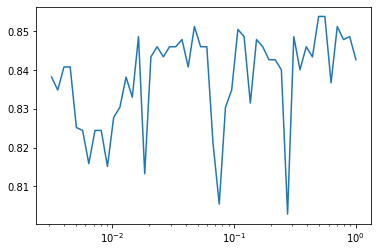

In [83]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch

test_len = round(len(ds) * 0.2)
train_val, test = random_split(ds, [len(ds) - test_len, test_len])
test_dl = DataLoader(test, batch_size=64)

def train_partial(frac: float = 1.0):
    torch.manual_seed(0)

    data_len = round(len(train_val) * frac)
    #print(f"{len(ds)=} {frac=} {[len(ds), len(ds) - data_len]=}")
    data, _ = random_split(train_val, [data_len, len(train_val) - data_len])

    val_len = max(1, round(len(data) * 0.2))
    train, val = random_split(data, [len(data) - val_len, val_len])

    train_dl = DataLoader(train, batch_size=64, shuffle=True)
    val_dl = DataLoader(val, batch_size=64)

    model = GpPrefModel([95, 64, 32, 16]).cuda()
    pairwise_fit(model, train_dl, val_dl)
    return model.test(test_dl)['accuracy']

import matplotlib.pyplot as plt
x = np.logspace(-2.5, 0, 50)
plt.plot(x, [train_partial(frac) for frac in x])
plt.xscale('log')

In [73]:
train_partial(0.1)

0.8582589626312256

In [81]:
ds.max_accuracy()

0.8661688684663986

In [31]:
model.posterior(torch.from_numpy(val[0][0]).cuda()).stddev

tensor([5.1094, 5.0989, 5.1151, 5.1273, 5.1902, 5.1028, 5.0881, 5.0986, 5.1028,
        5.1046, 5.1028, 5.1029, 5.1010, 5.1028, 5.1200, 5.1028, 5.1028, 5.1028,
        5.1404, 5.2478, 5.1028, 5.1028, 5.1028, 5.1666, 5.1028, 5.1029, 5.2058,
        5.1124, 5.1028, 5.1065, 5.2501, 5.1028, 5.1049, 5.1079, 5.1028, 5.1028,
        5.1138, 5.1894, 5.1190, 5.1060, 5.1028, 5.1028, 5.1018, 5.1028, 5.1398,
        5.1622, 5.1102, 5.1028, 5.1028, 5.1028, 5.1028, 5.0867, 5.1031, 5.1027,
        5.0975, 5.1230, 5.1028, 5.1237, 5.1133, 5.1184, 5.1028, 5.1028, 5.1028,
        5.1028, 5.1016, 5.0950, 5.1028, 5.1028, 5.0888, 5.1028, 5.1145, 5.1028,
        5.1028, 5.1028, 5.1092, 5.1028, 5.1068, 5.1028, 5.1028, 5.1056, 5.3261,
        5.1127, 5.1065, 5.1028, 5.1039, 5.1028, 5.0869, 5.1032, 5.1813, 5.1175,
        5.1028, 5.1035, 5.1025, 5.1028, 5.1067, 5.1028, 5.0894, 5.1078, 5.1182,
        5.0997, 5.1028, 5.1028, 5.1028, 5.1087, 5.1028, 5.1028, 5.1040, 5.1028,
        5.1028, 5.1067, 5.1028, 5.1786, 

In [13]:
train[0][0].shape

(120, 95)

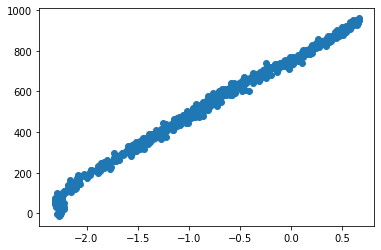

In [44]:
import matplotlib.pyplot as plt

plt.scatter(
    np.concatenate(rank_corr.scores, axis=0),
    np.concatenate(rank_corr.labels, axis=0),
)

(array([ 90.,  20.,  70., 107.,  85.,  92.,  78.,  55.,  70.,  85.]),
 array([-0.4168706 , -0.09938006,  0.21811047,  0.535601  ,  0.85309154,
         1.170582  ,  1.4880726 ,  1.8055631 ,  2.1230536 ,  2.4405441 ,
         2.7580347 ], dtype=float32),
 <BarContainer object of 10 artists>)

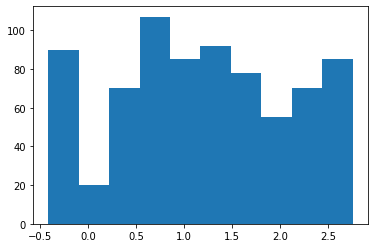

In [13]:
import matplotlib.pyplot as plt

plt.hist(np.concatenate(rank_corr.scores))

In [18]:
sum(param.numel() for param in model.parameters())

814593

In [44]:
np.concatenate(rank_corr.labels).shape

(752,)